   # The Variational Principle

$$ \hat{H}\psi = E\psi $$

$$ [-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}+V(x)]\psi=E\psi $$

Run all the import statements initially

In [27]:
# Used for the generation of random numbers in ground state calculation
import random
# Used for plotting
import matplotlib.pyplot as plt
# Used for the numerical calculations
import numpy
# Used for Fourier Analysis of results
from scipy import fftpack

Set the bounds of the calculation

In [28]:
lower_bound = -20
upper_bound = -lower_bound

Set the number of entries in the arrays

In [29]:
number_points = 2 ** 10 + 1

Calculate the spacing between points in the arrays, spanning the bounds.

In [30]:
step_size = (upper_bound - lower_bound) / number_points
inv_h_sq = step_size ** -2
half_h = step_size * 0.5

Set the value of $\hbar$ and $m$ used in the Schrodinger Equation and calculate the 
value of $-\frac{\hbar^2}{2m}$ as it's reused constantly in calculations.

Values taken from Wikipedia:
* $\hbar$: https://en.wikipedia.org/wiki/Planck_constant
* $m$: https://en.wikipedia.org/wiki/Electron

In [31]:
hbar = 1.054571817 * 10 ** -34  # eV
m = 9.1093837015 * 10 ** -31  # kg

Calculate the factor term as it's a constant and is reused throughout in calculations.

In [32]:
factor = -(hbar ** 2) / (2 * m)

Calculate the x span of the bounds and use it to generate
 the potential of the system.

In [33]:
x = numpy.linspace(lower_bound, upper_bound, num=number_points)

Define the potential function, it is a scalar function that has the same length as 
the given $\bar{r}$

Create sub potential functions that can be implemented in the main function for 
analytically solved examples:

In [34]:
def free_particle(r : numpy.ndarray):
    """
    The free particle potential represents an unbound particle in zero potential.
    :param r: The coordinates of the potential values
    :return: The free particle potential.
    """
    # The free particle has no potential.
    return numpy.zeros(len(r))

In [35]:
def finite_square_well(r : numpy.ndarray, V_0 = 1.0, wall_bounds = (200, 800)):
    """
    The infinite square well has defined potential within the bounds.
    :param r: The coordinates of the potential values.
    :param V_0: The potential value outside of the well
    :param wall_bounds: The points at which the well boundary starts. 
    :return: The infinite potential well function. 
    """
    # Get the number of points along the axis
    num_points = len(r)
    # The first number in wall_bounds is the index of the first well wall
    lower = wall_bounds[0]
    # the index of the second wall is the second index in wall_bounds 
    upper = num_points - wall_bounds[1]
    
    # Create the potential barrier of the well.
    lower_wall = numpy.array([V_0] * lower)
    # inside the well the potential is 0
    zeroes = numpy.zeros(num_points - lower - upper)
    # second potential barrier
    upper_wall = numpy.array([V_0] * upper)
    # Make the potential the combination of all the sections
    pot = numpy.concatenate((lower_wall, zeroes, upper_wall))
    
    return pot


In [36]:
def infinite_square_well(r : numpy.ndarray, wall_bounds = (200, 800)):
    """
    The infinite square well has defined potential within the bounds.
    :param r: The coordinates of the potential values.
    :param wall_bounds: The points at which the well boundary starts.
    :return: The infinite potential well function.
    """
    # Use the finite square well with infinite barriers.
    return finite_square_well(r, numpy.inf, wall_bounds)

In [37]:
def harmonic_oscillator(r : numpy.ndarray, k = 0.01):
    """
    The Harmonic Oscillator potential is quadratic about the origin.
    :param r: The coordinates of the potential values.
    :param k: Hooke's constant for the system
    :return: The harmonic potential.
    """
    # The potential energy formula:
    return 0.5 * k * r**2

In [38]:
def potential(r :numpy.ndarray):
    """
    The potential energy function of the system.
    :param r: The points on the axes of the system. 
    :return: A scalar ndarray of the values of the potential at each point in r. 
    """
    
    return harmonic_oscillator(r, 0.01)
    # return finite_square_well(r, 1, (200, 800))
    # return infinite_square_well(r, (200, 800))
    # return free_particle(r)

In [39]:
V = potential(x)

Define global arrays used in the calculations of the ground state so that when an 
entry is changed, on the corresponding values for that change in each array needs
t be tweaked instead of recalculating values for the entry array.

This way, computation time is greatly reduced, at the expense of ease of comprehension
of the code.

In [40]:
# Array containing all the H(psi), the hamiltonian operated on the wavefunction
global hamiltonians_array
# The tiny psi x H(psi)
global infinitesimal_energy_expectations
# The actual [psi x H(psi)]dx to sum over
global energies_array
# Array of magnitudes of the psi
global mag_psi
# The integrated magnitude of the wavefunction to sum over
global normalisation_array
# psi itself
global psi

Set the values of the arrays to be defaults.

In [41]:
hamiltonians_array = numpy.zeros(number_points, dtype=complex)

infinitesimal_energy_expectations = numpy.zeros(number_points)
energies_array = numpy.zeros(number_points)
normalisation_array = numpy.zeros(number_points)

psi = numpy.linspace(1, 1, number_points, dtype=complex)
mag_psi = psi.conj() * psi

Set the number of samples to generate when calculating the ground state of the
wavefunction

In [42]:
number_iterations = 50000

The `re_integrate()` function calculates the integration of a given function `f` at
the index `i` using the rectangular rule

In [43]:
def re_integrate(i: int, f: numpy.ndarray, step=step_size):
    # rectangular rule, at only the given index to change the array
    # sum the array after

    # Rectangular Rule:
    return f[i] * step

The method `second_derivative()` calculates the second derivative $\frac{d^2}{dx^2}$ of a give function `f` at
the index `i`. The default computation method is the 2nd order central difference method:
$$ f''(x)= \frac{f(x + h) - 2f(x) +f(x - h)}{h^2}$$ for the central bounds.

If `wrap` is `False`: The edge cases are calculated using the 2nd order backward and forward differences
respectively.

Forward: $$f''(x)=\frac{f(x) - f(x + h) - f(x + 2h)}{h^2}$$

Backward: $$f''(x)=\frac{f(x) - 2f(x-h) + f(x - 2h)}{h^2}$$

https://en.wikipedia.org/wiki/Finite_difference

In [44]:
def second_derivative(f: numpy.ndarray, i: int, wrap=False):
    """
    Calculates the 2nd order finite difference on the array f at the index i. If wrap is False,
    The edge cases are calculated using the forward and backward differences respectively, otherwise the central
    difference method is used throughout.
    :param f: The array to perform the differentiation on.
    :param i: The index to perform the differentiation at.
    :param wrap: Whether the edge cases wrap around or not.
    :return: The second order derivative at the index i.
    """
    # https: // en.wikipedia.org / wiki / Finite_difference
    # h = step size
    # Centre difference 2nd Derivative: d^2f / dx^2 = f''(x):
    # 1/h**2 * [f_i+1 - 2f_i + f_i-1]
    length = len(f)

    if not wrap and i + 1 >= length:
        # Use second order backward instead:
        # f'' = 1/h**2 * [f_i + f_i-2 - 2f_i-1]
        f_i = f[i]
        f_i_minus_1 = f[i - 1]
        f_i_minus_2 = f[i - 2]

        div2 = inv_h_sq * (f_i - 2 * f_i_minus_1 + f_i_minus_2)
        return div2

    if not wrap and i - 1 < 0:
        # Use second order forward instead:
        # f'' = 1/h**2 * [f_i + f_i+2 - 2f_i+1]
        f_i = f[i]
        f_i_plus_1 = f[i + 1]
        f_i_plus_2 = f[i + 2]

        div2 = inv_h_sq * (f_i - 2 * f_i_plus_1 + f_i_plus_2)
        return div2

    # Prevent the index going out of range, by looping back the index if it's too high
    f_i_plus_1 = f[(i + 1) % length]
    # Assume that the current index is in range
    f_i = f[i]
    # The lower index inherently loops back using negative indexing
    f_i_minus_1 = f[i - 1]

    # Current derivative.
    div_2 = inv_h_sq * (f_i_plus_1 - 2 * f_i + f_i_minus_1)
    return div_2

Calculates the Hamiltonian opertor on the given wavefunction `psi` for the given
index, using the following equation:

$$\hat H  \psi= -\frac{\hbar ^2}{2m} \frac{d^2}{dx^2}\psi + V(x)\psi$$

The index given corresponds to a coordinate $x$ where $\psi = \psi(x)$

In [45]:
def hamil(psi: numpy.ndarray, i: int):
    """
    Calculates the Hamiltonian of the given psi wavefunction at the given index in the array.
    :param psi: The wavefunction to operate on.
    :param i: The index to do the operation at.
    :return: The hamiltonian value at index i for the given psi.
    """

    Tpi = factor * second_derivative(psi, i)
    Vpi = V[i] * psi[i]

    return Tpi + Vpi

Calculates the value of <E\> at the give index `i` by taking the finite integral
at that index of:
$$\psi^*\hat H \psi$$ 

Later by summing over the array that these <E\> are stored in, we get the
approximation of <E\>=$\int{\psi^*\hat{H}\psi dx}$ 
as <E\> = $\sum{E_i}=\sum{\psi^*\hat{H}\psi}$

In [46]:
def recalculate_energy(psi: numpy.ndarray, i: int):
    """
    Recalculates the <E> at the given i for the given psi.
    :param psi: The wavefunction to use for the expectation value.
    :param i: The index to perform the calculation at.
    """
    # psi*
    # H psi
    # I = psi* x H psi
    # get at index i
    # Change array entry at only this point,
    # Then sum the array
    global hamiltonians_array
    global energies_array
    global infinitesimal_energy_expectations

    # alters the H*psi value at index i
    hamiltonians_array[i] = hamil(psi, i)

    # The value computed will be real, with a 0 imaginary component,
    # convert it to pure real number.
    infinitesimal_energy_expectations[i] = (psi[i].conj() * hamiltonians_array[i]).real

    energies_array[i] = re_integrate(i, infinitesimal_energy_expectations)

The final <E\> value:
Calculated as:

<E\> = $$ \frac{\int{\psi^* \hat{H} \psi dx}}{\int{\psi^*\psi dx}}$$

In [47]:
def energy_expectation():
    """
    Calculates the <E> energy expectation value from the energues_array array
    :return: The energy expectation value <E> as a scalar.
    """

    non_normalised_E = numpy.sum(energies_array).real
    norm = numpy.sum(normalisation_array)
    normalised_E = non_normalised_E / norm
    return normalised_E

After each change in the value of $\psi$ at the index `i` the corresponding magnitude
$|\psi|^2=\psi^*\psi$ needs to be recalculated, as well as it's integration 
$|\psi|^2 dx$ for the calculation $\sum{|\psi|^2}dx \approx \int{|\psi|^2dx}$.

In [48]:
def re_norm(psi: numpy.ndarray, i: int):
    """
    Recalculates the normalisation for the given psi wavefunction at the index i.
    :param psi: The wavefunction to re normalise.
    :param i: The index to perform the normalisation at.
    """
    global mag_psi
    global normalisation_array

    mag_psi[i] = psi[i].conj() * psi[i]
    normalisation_array[i] = re_integrate(i, mag_psi).real

Changes the value of $\psi$ at the given index by the give amount, and recalculates
the corresponding norms and energies.

In [49]:
def tweak_psi(psi: numpy.ndarray, pos: int, tweak: complex):
    """
    Changes the given wavefunction at the given index by the given amount, and renormalises the result.
    Calculates the new <E> for this changed wave function as well.
    :param psi: The wavefunction to modify.
    :param pos: The index of the wavefunction to modify.
    :param tweak: The amount to modify by.
    :return: The wavefunction's <E>.
    """
    # Tweak the value in psi by the given amount
    psi[pos] += tweak

    # Recompute the normalisation for this entry
    re_norm(psi, pos)
    # Re normalise psi
    # psi = normalise(psi)
    # normalise_arrays()

    # Re calculate the energy at this entry as well
    recalculate_energy(psi, pos)
    # The tweaked energy value is the new <E>
    E_new = energy_expectation()

    # return psi, E_new
    return E_new

Normalises the $\psi$ wavefunction using the norms logged each tweak above.

In [50]:
def normalise_psi(psi: numpy.ndarray):
    global normalisation_array
    global mag_psi

    norm = numpy.sum(normalisation_array)
    mag_psi /= norm
    psi /= numpy.sqrt(norm)
    normalisation_array /= norm

    return psi

Calculates the ground state wavefunction of the system with a give potential `V`.

In [51]:
def ground_state(number_iterations: int, seed="The Variational Principle"):
    """
    Calculates the ground state wavefunction for a given potential system, by fiinding the wavefunction with
    minimum expectation value in the energy <E>.
    :param number_iterations: Number of times the wavefunction should be modified to obtain the final result.
    :param seed: A seed for the random number generator.
    :return: The normalised gorund state wavefunction.
    """
    global energies_array
    global infinitesimal_energy_expectations

    psi = initialise()

    # psi is already normalised by initialise()
    # and E is already calculated.
    E = energy_expectation()

    # Get the random number generator, uses the given seed so that the results are repeatable
    random.seed(seed)

    # Iterate for the number of desired iterations
    for i in range(number_iterations):

        # Get a random x coord to sample
        rand_x = random.randrange(0, number_points)

        # Generate a random number to alter the entry by.
        rand_y = random.random()
        # rand_y = 0
        # imaginary_part = random.randint(0, 1)
        # # True is the imaginary part:
        # if imaginary_part:
        #     rand_y = complex(0, random.random())
        # else:
        #     rand_y = complex(random.random())

        E_up = tweak_psi(psi, rand_x, rand_y)
        E_down = tweak_psi(psi, rand_x, -2 * rand_y)
        # print("E before:", E)
        # E_b = E
        # E = tweak_psi(psi, rand_x, rand_y)
        tweak_psi(psi, rand_x, rand_y)
        # E_A = E
        # print("E after:", E)
        # dE = E_b - E_A
        # print("E diff:", dE, "\n")
        # if dE != 0:
        #     print("!!!")
        #     break

        # Compare energies for tweaking the entry up versus down, and keep the change
        # that results in a lower overall expectation value for the energy.
        if E_up < E_down and E_up < E:

            # If increasing the value in the entry results in a lower overall <E>
            # set the change and keep it
            E = tweak_psi(psi, rand_x, rand_y)

        elif E_down < E_up and E_down < E:

            # If decreasing the entry results in a lower overall <E>,
            # reduce the value and keep it.
            E = tweak_psi(psi, rand_x, -rand_y)

        # otherwise the psi should be left unchanged.
        # Same goes for Is, Es, norms, and the normalisation.

    # Normalise the final wavefunction
    # psi = normalise_psi(psi)
    # psi = normalise(psi)
    # A = numpy.sum(normalisation_array)
    # print(A)
    # psi /= numpy.sqrt(A)
    psi = normalise_psi(psi)

    return psi

Generates a Gaussian function to fit the range of the system, according to the 
Gaussian profile:

$p(x) = \frac{1}{\sqrt{ 2 \pi \sigma^2 }} e^{ - \frac{ (x - \mu)^2 } {2 \sigma^2} }$

where 

$\sigma$ is the standard deviation of the profile.

and

$\mu$ is the mean x-value of the profile which its centred around.

In [52]:
def generate_psi(start=lower_bound, stop=upper_bound, number_samples=number_points):
    """
    Creates a Gaussian distribution for the wavefunction psi
    :return:
    """

    x = numpy.linspace(start, stop, number_samples)

    mu = complex((lower_bound + upper_bound) / 2.0)
    sigma = complex((upper_bound - lower_bound) / 4.0)
    pi = complex(numpy.pi)
    A = 1 / numpy.sqrt(2 * pi * sigma ** 2)
    B = numpy.exp(- ((x - mu) ** 2) / (2 * sigma ** 2))
    psi = A * B

    return psi

Sets up the global arrays defined at the start for the given wavefunction, by populating their norms and 
energy expectations, then returning the normalised wavefunction.

In [53]:
def initialise():
    """
    Sets the initial values for the global arrays.
    """

    # psi = generate_psi()
    psi = numpy.linspace(1, 1, number_points)

    for i in range(number_points):
        re_norm(psi, i)
    # psi = normalise_psi(psi)

    for i in range(number_points):
        recalculate_energy(psi, i)

    return psi

A method mainly for debugging purposes that plots each of the global arrays against the domain x for
visualisation purposes.

In [54]:
def plurts():
    plt.plot(x, V)
    plt.title("Potential")
    plt.show()

    plt.plot(x, psi.real)
    plt.title("Real $\psi$")
    plt.show()

    plt.plot(x, psi.imag)
    plt.title("Imaginary $\psi$")
    plt.show()

    plt.plot(x, infinitesimal_energy_expectations)
    plt.title("Infinitesimal <E>s")
    plt.show()

    plt.plot(x, energies_array)
    plt.title("Infinitesimal Energies")
    plt.show()

    plt.plot(x, mag_psi)
    plt.title("$|\psi|^2$")
    plt.show()

    plt.plot(x, normalisation_array)
    plt.title("NORMS")
    plt.show()

    plt.plot(x, hamiltonians_array)
    plt.title("Infinitesimal Hamiltonians:")
    plt.show()

The actual running of the code to calculate a ground state wavefunction. The wavefunction and arrays are 
set up through `initialise()` then the change in energy between the initial guess and final answer 
are shown for illustrative purposes, while the wavefunction is calculated through `ground_state()`

In [60]:
# psi = initialise()
# E = energy_expectation()
# print("Initial Energy:", E)
# plurts()
psi = ground_state(number_iterations)
E = energy_expectation()
print("Final Energy:", E)
# plurts()

Final Energy: 0.06746447392971454


Plot the final wavefunction produced from the calculations.

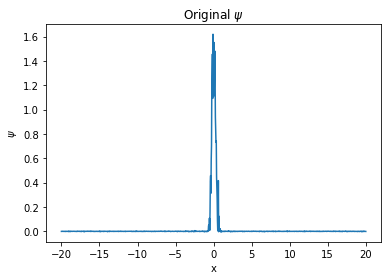

In [61]:
plt.plot(x, psi.real)
plt.title("Original $\psi$")
plt.xlabel("x")
plt.ylabel("$\psi$")
plt.show()

A short method to perform some fast fourier transforms on the produced ground state function, so that
the noise can be removed from the result if desired.

In [57]:
def fourier_analysis(psi):
    # Do the FT on the wavefunction
    fft_psi = fftpack.fft(psi.real)
    # Half the produced value as the FT is symmetric
    fft_psi = fft_psi[:int(len(fft_psi) / 2)]
    # plt.plot(x, fft_psi)

    # Plot the FT to visualise the results.
    # plt.plot(fft_psi)
    # plt.show()

    # Chop the FT to keep only the most important harmonics
    fft_psi = fft_psi[:33]
    # Plot the minimised FT
    # plt.plot(fft_psi)
    # plt.show()

    # Perform an inverse FT to get the smoothed wavefunction back
    psi = fftpack.ifft(fft_psi)

    # Plot the final wavefunction to show the result.
    x_range = numpy.linspace(lower_bound, upper_bound, len(psi.real))
    plt.plot(x_range, psi.real)
    plt.title("Smoothed Wavefunction $\psi$")
    plt.xlabel("x")
    plt.ylabel("$\psi$")
    plt.show()

In [58]:
# fourier_analysis(psi)
